In [24]:
## Sentiment and Nature Classification using Hyperparameter-Tuned Machine Learning Models on Lexicon Data (Nature prediction)

# This code snippet preprocesses lexicon data (variables: score, sentiment, nature), encodes categorical features (sentiment_encoded, nature_encoded), 
# and scales features (X_scaled). It then splits the data for training and testing, performs hyperparameter tuning on several classifiers 
# (SVM, Decision Tree, Random Forest, Gaussian Naive Bayes), and evaluates model performance using accuracy, precision, recall, and F1-score. 
# The results are stored in a DataFrame (results_df) for comparison.

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm  # Progress bar for Jupyter Notebooks

# Specify file path for the dataset (use raw string to handle Windows backslashes correctly)
file_path = r"H:\My Drive\Hons\INF 791\Assignments\Assignment 3\corrected_lexicon.xlsx"

# Load the dataset from the specified Excel file into a DataFrame
df = pd.read_excel(file_path)


# Rename columns to match the expected structure
df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# Drop rows with missing values in critical columns ('score', 'sentiment', 'nature') to avoid issues in processing
df = df.dropna(subset=['score', 'sentiment', 'nature'])

# Encode categorical 'sentiment' and 'nature' columns to numeric labels for machine learning models
label_encoder_sentiment = LabelEncoder()
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentiment'])

label_encoder_nature = LabelEncoder()
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Filter out classes in 'nature' that have fewer than 2 instances, as they could cause issues during stratified splits
class_counts = df['nature'].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index
df = df[df['nature'].isin(classes_to_keep)]

# Re-encode 'nature' after filtering to ensure classes remain properly numbered
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Prepare feature matrix (X) with 'score' and encoded 'sentiment', and target vector (y) with encoded 'nature'
X = df[['score', 'sentiment_encoded']]
y = df['nature_encoded']

# Convert 'score' column to numeric, filling NaNs with 0, to handle non-numeric values and ensure no missing data in X
X.loc[:, 'score'] = pd.to_numeric(X['score'], errors='coerce').fillna(0)

# Scale features to standardize values for optimal model performance, especially for distance-based algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets (80-20 split) with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # Stratify by y to keep class distributions consistent
)

# Define hyperparameter grids for each model, specifying ranges for critical parameters to optimize performance
param_grids = {
    "SVM": {
        'C': [0.1, 1, 10],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Kernel types for SVM
        'gamma': ['scale', 'auto']  # Kernel coefficient
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10],  # Depth of the tree
        'min_samples_split': [2, 5],  # Minimum samples required to split a node
        'min_samples_leaf': [1, 2]  # Minimum samples required to be at a leaf node
    },
    "Random Forest": {
        'n_estimators': [50, 100],  # Number of trees in the forest
        'max_depth': [None, 5, 10],  # Maximum depth of trees
        'min_samples_split': [2, 5],  # Minimum samples required to split a node
        'min_samples_leaf': [1, 2]  # Minimum samples required to be at a leaf node
    },
    "Gaussian Naive Bayes": {
        'var_smoothing': [1e-9, 1e-8, 1e-7]  # Smoothing parameter for Gaussian Naive Bayes
    }
}

# Define the models to evaluate
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB()
}

# Function to perform grid search for a single model with progress bar
def perform_grid_search(model_name, model, param_grid):
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='accuracy', 
        cv=5, 
        verbose=0, 
        n_jobs=-1
    )
    
    # Use tqdm to display the progress
    with tqdm(total=len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) 
              if model_name == "SVM" else len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) 
              if model_name == "Decision Tree" else len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) 
              if model_name == "Random Forest" else len(param_grid['var_smoothing']), desc=f"Training {model_name}", leave=True) as pbar:
        grid_search.fit(X_train, y_train)
        pbar.update(1)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}\n")
    return best_model

# Store the best models in a dictionary
best_models = {}

# Run grid search for each model separately with progress tracking
for model_name, model in models.items():
    best_models[model_name] = perform_grid_search(model_name, model, param_grids[model_name])

# Evaluate the best models on the test set with progress bar
results = []
for name, model in tqdm(best_models.items(), desc="Evaluating models"):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Append the results as a dictionary to the list
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

# Sort results by Accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Display the results
print("Hyperparameter Tuning Results:")
display(results_df)

Performing Grid Search for SVM...


Training SVM:   0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\Dihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.6743

Performing Grid Search for Decision Tree...


Training Decision Tree:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation accuracy for Decision Tree: 0.6743

Performing Grid Search for Random Forest...


C:\Users\Dihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Training Random Forest:   0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\Dihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy for Random Forest: 0.6755

Performing Grid Search for Gaussian Naive Bayes...


Training Gaussian Naive Bayes:   0%|          | 0/3 [00:00<?, ?it/s]

Best parameters for Gaussian Naive Bayes: {'var_smoothing': 1e-09}
Best cross-validation accuracy for Gaussian Naive Bayes: 0.6284



C:\Users\Dihan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Evaluating models:   0%|          | 0/4 [00:00<?, ?it/s]

Hyperparameter Tuning Results:


Model  Accuracy  Precision    Recall  F1-Score
2         Random Forest  0.655763   0.611037  0.655763  0.561988
0                   SVM  0.654206   0.605091  0.654206  0.559285
1         Decision Tree  0.654206   0.604437  0.654206  0.558882
3  Gaussian Naive Bayes  0.599688   0.540980  0.599688  0.547012

In [ ]:
## Score Prediction and Classification using Hyperparameter-Tuned Machine Learning Models on Lexicon Data with Binned Score Analysis

# This code performs regression on lexicon data, predicting the score variable based on categorical data (sentiment and nature). 
# It preprocesses data, encodes categorical variables, scales features, and uses grid search to tune hyperparameters for several 
# regression models (SVM, Decision Tree, Random Forest). The models are evaluated on mean squared error, mean absolute error, and R². 
# Additionally, by discretizing the continuous score into bins, it evaluates classification metrics (accuracy, precision, recall, F1-score) 
# for regression predictions and Gaussian Naive Bayes as a classifier.

In [26]:
# Import necessary libraries for data processing, modeling, and evaluation
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB  # Naive Bayes for classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm  # Progress bar for Jupyter Notebooks

# Load dataset
df = pd.read_excel(file_path)

# Rename columns to match expected structure
df.columns = ['ciluba', 'french', 'english', 'afrikaans', 'zulu', 'sepedi', 'score', 'sentiment', 'nature']

# Drop rows with missing values in key columns ('score', 'sentiment', 'nature')
df = df.dropna(subset=['score', 'sentiment', 'nature'])

# Encode categorical variables for model compatibility
label_encoder_sentiment = LabelEncoder()
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentiment'])

label_encoder_nature = LabelEncoder()
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Filter out classes with fewer than 2 instances in 'nature' column for model stability
class_counts = df['nature'].value_counts()
classes_to_keep = class_counts[class_counts >= 2].index
df = df[df['nature'].isin(classes_to_keep)]

# Re-encode after filtering to update 'nature' labels
df['nature_encoded'] = label_encoder_nature.fit_transform(df['nature'])

# Define feature set (X) and target (y)
X = df[['nature_encoded', 'sentiment_encoded']]
y = pd.to_numeric(df['score'], errors='coerce').fillna(0)

# Scale features for optimal model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets for regression analysis
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42  # Fixed split for reproducibility
)

# Define hyperparameter grids for grid search tuning
param_grids = {
    "SVM": {
        'C': [0.1, 1, 10], 
        'kernel': ['linear', 'rbf'], 
        'gamma': ['scale', 'auto']
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "Random Forest": {
        'n_estimators': [50, 100], 
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

# Define regression models for evaluation
models = {
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Function to perform grid search on a single model with progress bar
def perform_grid_search(model_name, model, param_grid):
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='neg_mean_squared_error',  # Use MSE for regression
        cv=5, 
        verbose=0, 
        n_jobs=-1
    )
    
    # Set up progress bar based on parameter grid size
    with tqdm(total=len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) 
              if model_name == "SVM" else len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) 
              if model_name == "Decision Tree" else len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']), desc=f"Training {model_name}", leave=True) as pbar:
        grid_search.fit(X_train, y_train)
        pbar.update(1)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_:.4f}\n")
    return best_model

# Dictionary to store the best models for each regressor
best_models = {}

# Run grid search for each model and store the best models
for model_name, model in models.items():
    best_models[model_name] = perform_grid_search(model_name, model, param_grids[model_name])

# Evaluate the best models on the test set using regression metrics
results = []
for name, model in tqdm(best_models.items(), desc="Evaluating models"):
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics for regression
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append results as a dictionary
    results.append({
        "Model": name,
        "Mean Squared Error": mse,
        "Mean Absolute Error": mae,
        "R^2 Score": r2
    })

# Convert the regression results into a DataFrame and sort by R^2 Score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2 Score", ascending=False)

# Display regression results
print("Hyperparameter Tuning Results (Regression):")
display(results_df)

# For classification-like evaluation, add Gaussian Naive Bayes and bin the scores
best_models["Gaussian Naive Bayes"] = GaussianNB()

# Prepare score values for binning
y_test_array = y_test.to_numpy().reshape(-1, 1)
y_train_array = y_train.to_numpy().reshape(-1, 1)

# Discretize scores into bins for classification-like metrics
n_bins = 3  # Adjust number of bins as needed
binning = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')  # Equal-width binning

# Bin y values to categorical
y_test_binned = binning.fit_transform(y_test_array).astype(int).ravel()
y_train_binned = binning.fit_transform(y_train_array).astype(int).ravel()

# Train Gaussian Naive Bayes on binned y values
best_models["Gaussian Naive Bayes"].fit(X_train, y_train_binned)

# Evaluate models using classification metrics on binned scores
classification_results = []
for name, model in tqdm(best_models.items(), desc="Evaluating models (Classification-like)"):
    # Predict on test set and bin predictions
    y_pred = model.predict(X_test)
    y_pred_array = np.array(y_pred).reshape(-1, 1)
    y_pred_binned = binning.transform(y_pred_array).astype(int).ravel()
    
    # Calculate classification metrics
    accuracy = accuracy_score(y_test_binned, y_pred_binned)
    precision = precision_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)
    recall = recall_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)
    f1 = f1_score(y_test_binned, y_pred_binned, average='weighted', zero_division=0)
    
    # Append classification results
    classification_results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert classification results to a DataFrame and sort by Accuracy
classification_results_df = pd.DataFrame(classification_results)
classification_results_df = classification_results_df.sort_values(by="Accuracy", ascending=False)

# Display classification-like results
print("Classification-like Results based on Binned Scores:")
display(classification_results_df)

Performing Grid Search for SVM...


Training SVM:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score for SVM: -2.7594

Performing Grid Search for Decision Tree...


Training Decision Tree:   0%|          | 0/12 [00:00<?, ?it/s]

Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score for Decision Tree: -2.7631

Performing Grid Search for Random Forest...


Training Random Forest:   0%|          | 0/24 [00:00<?, ?it/s]

Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score for Random Forest: -2.7483



Evaluating models:   0%|          | 0/3 [00:00<?, ?it/s]

Hyperparameter Tuning Results (Regression):


Model  Mean Squared Error  Mean Absolute Error  R^2 Score
1  Decision Tree            2.716099             1.230215   0.565889
2  Random Forest            2.716559             1.230556   0.565816
0            SVM            2.735364             1.235367   0.562810

Evaluating models (Classification-like):   0%|          | 0/4 [00:00<?, ?it/s]

Classification-like Results based on Binned Scores:


Model  Accuracy  Precision    Recall  F1-Score
0                   SVM  0.476636   0.535862  0.476636  0.343272
1         Decision Tree  0.475078   0.535018  0.475078  0.342174
2         Random Forest  0.475078   0.535018  0.475078  0.342174
3  Gaussian Naive Bayes  0.468847   0.219818  0.468847  0.299307

In [ ]:
## Confusion Matrices for Binned Score Predictions across Various Models

# This set of confusion matrices displays the classification performance of four machine learning models – SVM, Decision Tree, Random Forest, 
# and Gaussian Naive Bayes – on discretized (binned) score predictions. Each matrix compares true versus predicted bins for the score, 
# illustrating how well each model distinguishes between different score ranges. Diagonal elements indicate correct classifications, 
# while off-diagonal elements show misclassifications. This visualization helps in assessing each model’s accuracy and potential biases 
# in predicting specific score ranges.

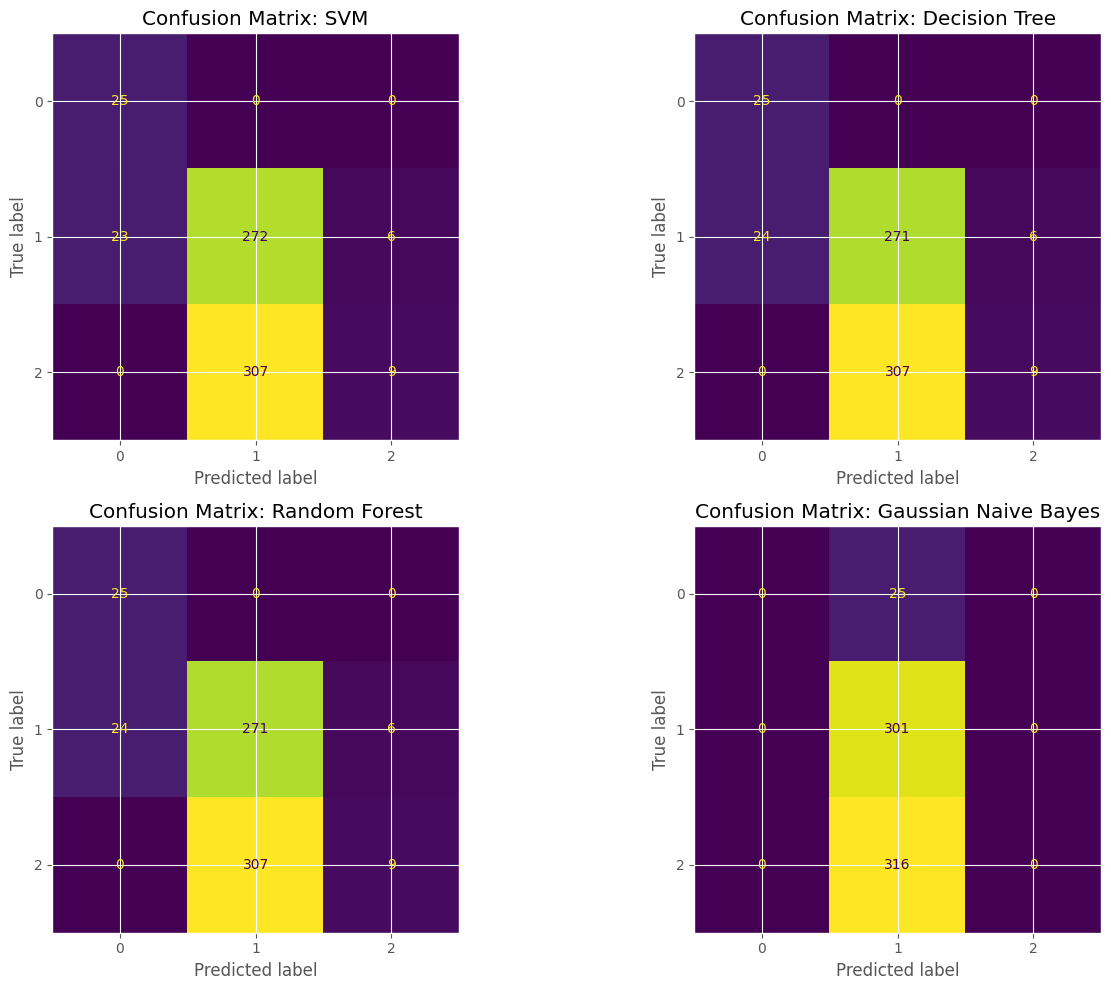

In [27]:
# Confusion Matrices
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# List of models to evaluate for confusion matrices
models_to_plot = ['SVM', 'Decision Tree', 'Random Forest', 'Gaussian Naive Bayes']

for i, name in enumerate(models_to_plot):
    # Make predictions
    y_pred = best_models[name].predict(X_test)
    
    # Convert predictions to binned values
    y_pred_array = np.array(y_pred).reshape(-1, 1)  # Convert to numpy array and reshape
    y_pred_binned = binning.transform(y_pred_array).astype(int).ravel()  # Bin the predictions
    
    # Create the confusion matrix
    cm = confusion_matrix(y_test_binned, y_pred_binned)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[i//2, i%2], colorbar=False)
    ax[i//2, i%2].set_title(f'Confusion Matrix: {name}')

plt.tight_layout()
plt.show()


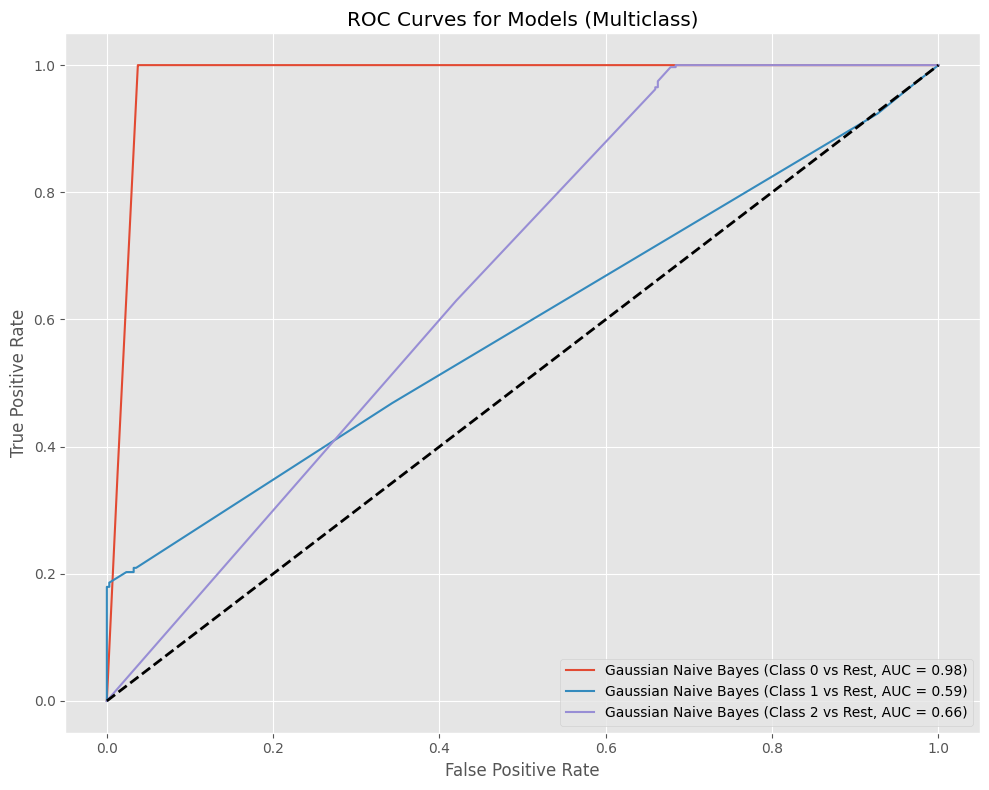

In [28]:
## Multiclass ROC Curves for Binned Score Predictions using One-vs-Rest Strategy

# This plot shows the ROC (Receiver Operating Characteristic) curves for each class in a multiclass setup, applying the 
# one-vs-rest strategy across two models, Random Forest and Gaussian Naive Bayes. Each line represents the ROC curve for 
# distinguishing one class (bin) from the rest, with the AUC (Area Under the Curve) value indicating model performance for 
# each class. The diagonal line serves as a baseline, where an AUC of 0.5 suggests no discrimination. Curves that approach 
# the top-left corner show higher sensitivity and specificity for that class, providing insights into each model's performance 
# across different score ranges.


from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC Curves for Multiclass (One-vs-Rest for each class)
fig, ax = plt.subplots(figsize=(10, 8))

# Models that support `predict_proba`
models_to_plot = ['Random Forest', 'Gaussian Naive Bayes']

# Function to plot ROC curves for each class in a multiclass setting
def plot_multiclass_roc(model, X_test, y_test_binned, model_name):
    # Get the predicted probabilities for each class
    y_prob = model.predict_proba(X_test)

    # Plot ROC curve for each class (one-vs-rest)
    for i in range(len(np.unique(y_test_binned))):  # Loop over each class
        fpr, tpr, _ = roc_curve(y_test_binned == i, y_prob[:, i])
        auc = roc_auc_score(y_test_binned == i, y_prob[:, i])
        ax.plot(fpr, tpr, label=f'{model_name} (Class {i} vs Rest, AUC = {auc:.2f})')

# Plot ROC curve for Random Forest
if hasattr(best_models['Random Forest'], 'predict_proba'):
    plot_multiclass_roc(best_models['Random Forest'], X_test, y_test_binned, 'Random Forest')

# Plot ROC curve for Gaussian Naive Bayes
if hasattr(best_models['Gaussian Naive Bayes'], 'predict_proba'):
    plot_multiclass_roc(best_models['Gaussian Naive Bayes'], X_test, y_test_binned, 'Gaussian Naive Bayes')

# Plot ROC curve for SVM (SVC)
if hasattr(best_models['SVM'], 'predict_proba'):
    plot_multiclass_roc(best_models['SVM'], X_test, y_test_binned, 'SVM')

# Plot baseline
ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Models (Multiclass)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
